![image.png](https://i.imgur.com/a3uAqnb.png)

# 🎛️ 1D CNN for Tajweed Audio Classification

In this notebook, we will implement a **1D Convolutional Neural Network (CNN)** for classifying **Tajweed rules** in Quranic recitation audio.

**1D CNN** is a powerful architecture for processing sequential data like audio waveforms. Unlike traditional 2D CNNs used for images, 1D CNNs operate directly on the raw audio signal, learning temporal patterns and features that distinguish different Tajweed rules.

This notebook demonstrates end-to-end audio classification using PyTorch and torchaudio.

## 🎛️ Configuration & Imports

Below we set all hyperparameters in one place (`CONFIG`), and import the libraries you'll need.

**Key Parameters Explained:**
- **`SAMPLE_RATE`**: 16kHz - Standard rate for speech processing, balancing quality and computational efficiency
- **`MAX_SEC`**: 4.0 seconds - Fixed duration for all audio clips to ensure consistent input size
- **`MAX_LEN`**: 64,000 samples - Calculated as SAMPLE_RATE × MAX_SEC
- **`BATCH`**, **`EPOCHS`**, **`LR`**: Training hyperparameters optimized for audio classification
- **`K_FOLDS`**: 5-fold cross-validation for robust model evaluation

We use:
- **torchaudio** for audio I/O and preprocessing
- **torchmetrics** for F1-score calculation (important for potentially imbalanced classes)
- **tqdm** for training progress visualization

In [ ]:
from IPython.display import clear_output
# run this if you are working on colab(disgusting 🤮)
!pip install torchmetrics

clear_output()


In [1]:
import kagglehub

path = kagglehub.dataset_download("mohammad2012191/tajweed-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/tajweed-dataset


In [4]:
from pathlib import Path
import random, os
import numpy as np, pandas as pd
import torch
import torch.nn as nn, torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from torchmetrics.classification import F1Score
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# 🎲 Set random seeds for reproducibility across all libraries
SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

# 🎵 Audio processing parameters
SAMPLE_RATE = 16_000  # 16kHz sampling rate - optimal for speech
MAX_SEC     = 4.0     # Fixed duration for all audio clips
MAX_LEN     = int(SAMPLE_RATE * MAX_SEC)  # 64,000 samples per clip

# 🏋️ Training hyperparameters
BATCH    = 32   # Batch size - balance between memory usage and gradient stability
EPOCHS   = 3   # Number of training epochs
LR       = 3e-4 # Learning rate - conservative value for stable training
K_FOLDS  = 5    # Number of cross-validation folds

# 📁 Dataset paths
WORK_DIR  = Path(path)
TRAIN_CSV = WORK_DIR/"train.csv"  # CSV with audio file IDs and labels
TRAIN_DIR = WORK_DIR/"train"      # Directory containing .wav files

# 🖥️ Device configuration - use GPU if available for faster training
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"🖥️ Using device: {DEVICE}")

🖥️ Using device: cuda


## 🔍 Exploratory Data Analysis (EDA)

Before diving into model training, we need to understand our dataset structure and characteristics. This section will help us:

### **🎵 Key Analysis Steps:**
1. **Dataset Overview**: Understanding file structure, sample counts, and label distribution
2. **Reciter Analysis**: Examining which reciters are included and their representation
3. **Label Distribution**: Checking class balance for our 4 Tajweed rules
4. **Data Quality Assessment**: Ensuring our training data is well-distributed

### **📊 Why EDA Matters for Audio:**
- **Class Imbalance**: Audio datasets often have uneven class distributions
- **Speaker Diversity**: Different reciters may have varying styles and audio quality
- **Feature Understanding**: Knowing our target classes helps in model interpretation

### **🎨 Visualization Strategy:**
We'll create visualizations to understand:
- Reciter distribution across the dataset
- Tajweed rule frequency and balance
- Overall dataset characteristics that might affect training

📊 Dataset Overview:
   Total samples: 1,515
   Number of classes: 4
   Classes: ['Idgham', 'Ikhfa', 'Iqlab', 'Izhar']
   Number of reciters: 8


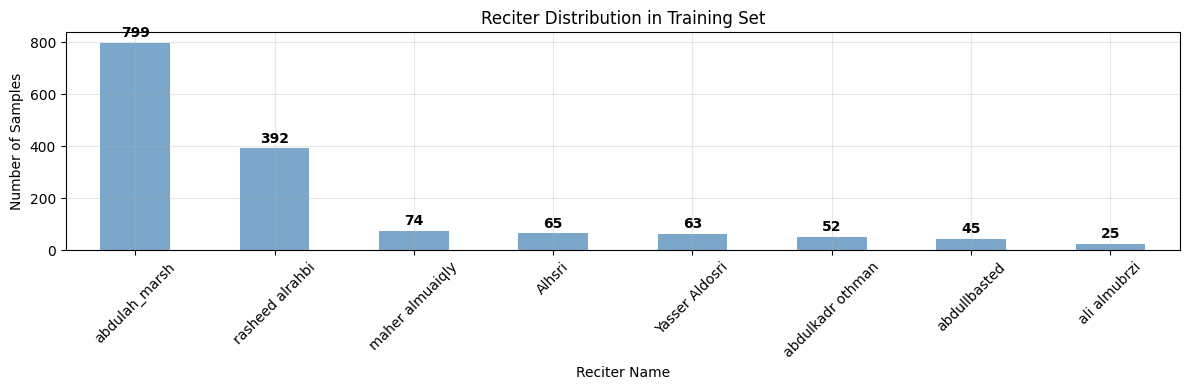


🏷️ Tajweed Rule Distribution:
   Idgham         :  527 samples ( 34.8%)
   Izhar          :  429 samples ( 28.3%)
   Ikhfa          :  404 samples ( 26.7%)
   Iqlab          :  155 samples ( 10.2%)

⚖️ Class Balance Analysis:
   Imbalance ratio: 3.40:1
   ⚠️ Significant class imbalance detected - consider stratified sampling


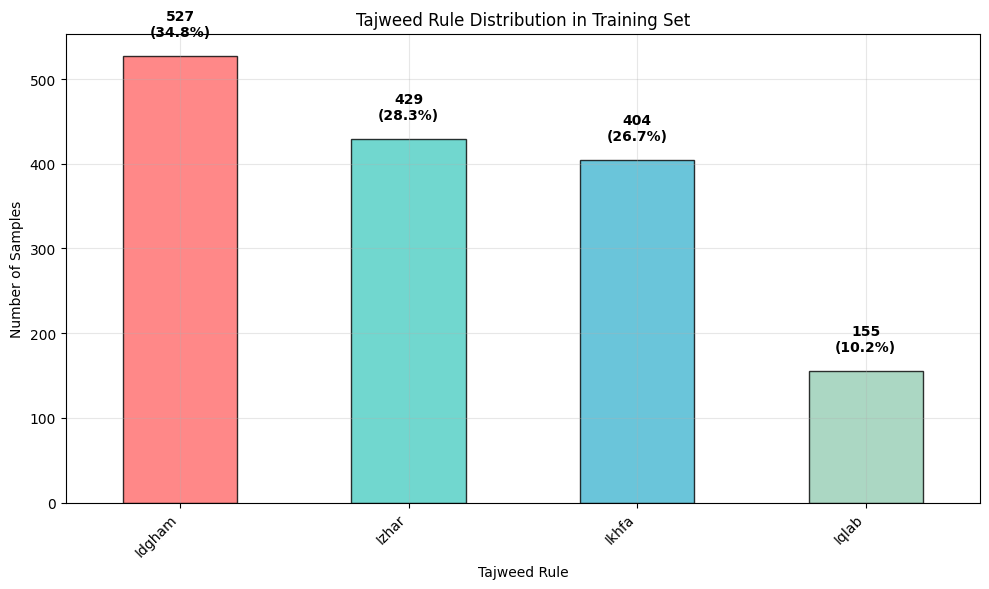

In [5]:
# 🔍 Load and explore the Tajweed dataset
train_df = pd.read_csv(TRAIN_CSV)

# Create label encodings for model training
# LabelEncoder converts string labels to integers (required for PyTorch)
le = LabelEncoder().fit(train_df["label_name"])
train_df["y"] = le.transform(train_df["label_name"])

print(f"📊 Dataset Overview:")
print(f"   Total samples: {len(train_df):,}")
print(f"   Number of classes: {len(le.classes_)}")
print(f"   Classes: {list(le.classes_)}")
print(f"   Number of reciters: {train_df.sheikh_name.nunique()}")

# Visualize reciter distribution - important for understanding data bias
fig, axes = plt.subplots(1,1, figsize=(12,4), sharey=True)
reciter_counts = train_df.sheikh_name.value_counts()
reciter_counts.plot.bar(ax=axes, title="Reciter Distribution in Training Set",
                       color='steelblue', alpha=0.7)
axes.set_xlabel("Reciter Name")
axes.set_ylabel("Number of Samples")
axes.tick_params(axis='x', rotation=45)
axes.grid(True, alpha=0.3)

# Add count labels on bars for better readability
for i, (reciter, count) in enumerate(reciter_counts.items()):
    axes.text(i, count + 10, str(count), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze label distribution - crucial for understanding class balance
print(f"\n🏷️ Tajweed Rule Distribution:")
label_counts = train_df.label_name.value_counts()
for rule, count in label_counts.items():
    percentage = (count / len(train_df)) * 100
    print(f"   {rule:<15}: {count:4d} samples ({percentage:5.1f}%)")

# Check for class imbalance
imbalance_ratio = label_counts.max() / label_counts.min()
print(f"\n⚖️ Class Balance Analysis:")
print(f"   Imbalance ratio: {imbalance_ratio:.2f}:1")
if imbalance_ratio > 3:
    print("   ⚠️ Significant class imbalance detected - consider stratified sampling")
else:
    print("   ✅ Reasonable class balance")

# Label histogram with enhanced styling
plt.figure(figsize=(10,6))
bars = label_counts.plot.bar(title="Tajweed Rule Distribution in Training Set",
                            color=['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4'],
                            alpha=0.8, edgecolor='black', linewidth=1)
plt.xlabel("Tajweed Rule")
plt.ylabel("Number of Samples")
plt.xticks(rotation=45, ha='right')
plt.grid(True, alpha=0.3)

# Add value labels and percentages on bars
for i, (rule, count) in enumerate(label_counts.items()):
    percentage = (count / len(train_df)) * 100
    plt.text(i, count + 20, f'{count}\n({percentage:.1f}%)',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 🎙️ Dataset & Audio Preprocessing

Our PyTorch Dataset class handles the complete audio preprocessing pipeline:

### 🔹 **Audio Processing Steps:**
1. **Loading**: Read `.wav` files using torchaudio
2. **Resampling**: Ensure consistent 16kHz sampling rate
3. **Mono Conversion**: Convert stereo to mono for simpler processing
4. **Length Normalization**: Pad short clips, trim long clips to exactly 4 seconds


In [26]:
from pathlib import Path
import random, torch
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset

class TajweedDataset(Dataset):
    """
    🎙️ PyTorch Dataset for Tajweed Audio Classification

    This dataset handles loading, preprocessing, and augmentation of audio files
    for training a 1D CNN on Tajweed rule classification.

    Key Features:
    - Automatic resampling to target sample rate
    - Length normalization (pad/trim to fixed duration)
    - Flexible return format for training vs inference

    Args:
        df (pd.DataFrame): DataFrame with 'id' column and optionally 'y' (labels)
        folder (str/Path): Directory containing audio files named as '{id}.wav'
        transforms (callable): Audio augmentation pipeline (None for inference)
        return_id (bool): If True, return (audio, id) for inference mode
                         If False, return (audio, label) for training mode
    """

    def __init__(self, df, folder, transforms=None):
        self.df = df.reset_index(drop=True)
        self.folder = Path(folder)
        self.transforms = transforms

        print(f"📁 Dataset initialized: {len(self.df)} samples from {self.folder}")

    def _pad_trim(self, wav: torch.Tensor) -> torch.Tensor:
        """
        🔧 Normalize audio length to exactly MAX_LEN samples

        - If too short: Zero-pad at the end
        - If too long: Center-crop to target length

        This ensures all inputs have identical shape for batch processing.
        """
        current_len = wav.size(1)

        if current_len < MAX_LEN:
            # Pad with zeros at the end
            padding = MAX_LEN - current_len
            return F.pad(wav, (0, padding))
        elif current_len > MAX_LEN:
            # Center crop to target length
            start_idx = (current_len - MAX_LEN) // 2
            return wav[:, start_idx:start_idx + MAX_LEN]
        else:
            return wav

    def __getitem__(self, idx):
        row = self.df.iloc[idx]

        # 📂 Load audio file
        audio_path = self.folder / f"{row['id']}.wav"

        # Load waveform and sample rate
        wav, sr = torchaudio.load(str(audio_path))

        # 🔄 Resample if necessary to ensure consistent sample rate
        if sr != SAMPLE_RATE:
            wav = torchaudio.functional.resample(wav, sr, SAMPLE_RATE)

        # 🎛️ Apply augmentations if provided (only during training)
        if self.transforms is not None:
            wav = self.transforms(wav)

        # 🎵 Convert to mono by averaging channels
        wav = wav.mean(dim=0, keepdim=True)

        # 📏 Normalize length to exactly MAX_LEN samples
        wav = self._pad_trim(wav)

        # 🔄 Sample-wise amplitude normalization
        wav = wav / (wav.abs().max() + 1e-9)

        return wav, torch.tensor(row["y"], dtype=torch.long)

    def __len__(self):
        return len(self.df)

## 🔊 Audio Waveform Visualization

Visualizing raw audio waveforms helps us understand:
- **Amplitude Patterns**: How loud different segments are
- **Temporal Structure**: How audio evolves over time  
- **Variability**: Differences between samples and Tajweed rules
- **Quality Check**: Ensuring our preprocessing works correctly

Unlike spectrograms which show frequency content, raw waveforms display the actual signal our 1D CNN will process.

📁 Dataset initialized: 4 samples from /kaggle/input/tajweed-dataset/train


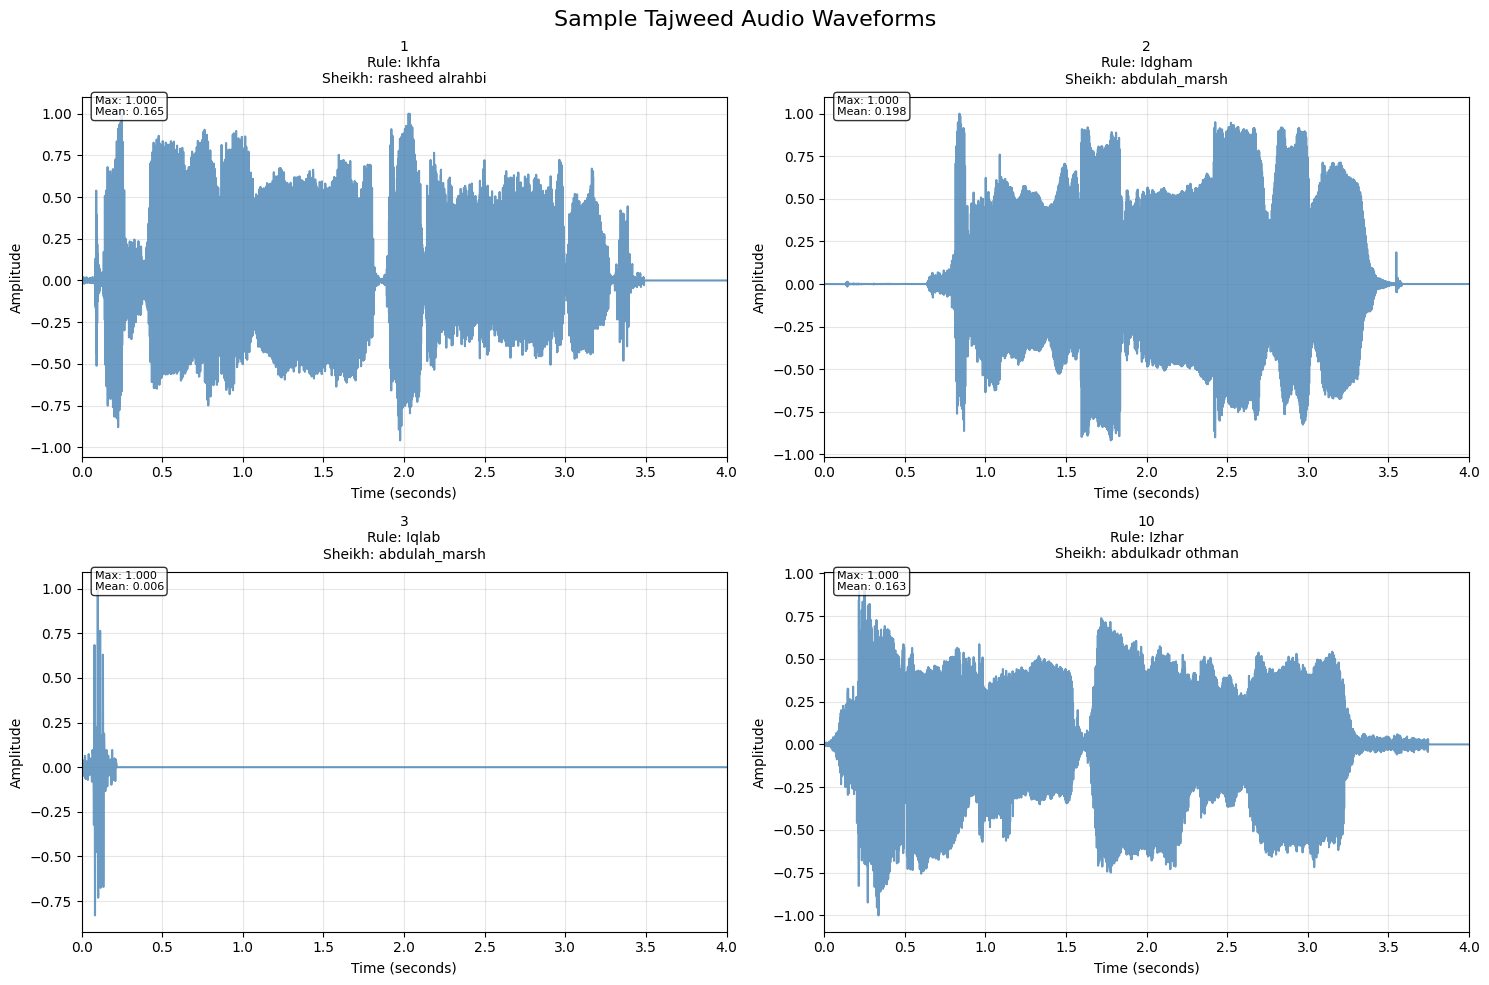

In [27]:
from IPython.display import Audio, display   

# 🖼️ Visualize sample waveforms to understand our data

# Select 4 random samples with different labels for diversity
sample_data = train_df.groupby('label_name').head(1).head(4)
sample_dataset = TajweedDataset(sample_data, TRAIN_DIR, transforms=None)

plt.figure(figsize=(15, 10))

for i in range(len(sample_dataset)):
    wav, label_idx = sample_dataset[i]
    row = sample_dataset.df.iloc[i]

    file_id = row["id"]
    label_name = row["label_name"]
    sheikh_name = row["sheikh_name"]

    # Create time axis for x-axis (in seconds)
    time_axis = np.linspace(0, MAX_SEC, len(wav.squeeze()))

    plt.subplot(2, 2, i+1)
    plt.plot(time_axis, wav.squeeze().numpy(), color='steelblue', alpha=0.8)
    plt.title(f"{file_id}\nRule: {label_name}\nSheikh: {sheikh_name}",
              fontsize=10, pad=10)
    plt.xlabel("Time (seconds)")
    plt.ylabel("Amplitude")
    plt.grid(True, alpha=0.3)
    plt.xlim(0, MAX_SEC)

    # Add some statistics
    max_amp = wav.abs().max().item()
    mean_amp = wav.abs().mean().item()
    plt.text(0.02, 0.95, f"Max: {max_amp:.3f}\nMean: {mean_amp:.3f}",
             transform=plt.gca().transAxes, fontsize=8,
             bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

    display(Audio(wav.squeeze().numpy(), rate=SAMPLE_RATE))  

plt.suptitle("Sample Tajweed Audio Waveforms", fontsize=16, y=0.98)
plt.tight_layout()
plt.show()


## 🏗️ 1D CNN Architecture

Our 1D CNN is specifically designed for audio classification with the following key components:

In [19]:
class CNN1D(nn.Module):
    """
    🏗️ 1D Convolutional Neural Network for Audio Classification

    This architecture processes raw audio waveforms using temporal convolutions
    to learn hierarchical features for Tajweed rule classification.

    Architecture Flow:
    Raw Audio → Conv Blocks → Global Pooling → Classification

    Key Features:
    - Direct waveform processing (no spectrograms needed)
    - Progressive feature extraction through conv layers
    - Batch normalization for stable training
    - Global average pooling for translation invariance
    - Compact classifier head
    """

    def __init__(self, n_classes):
        super().__init__()

        # 🔧 Feature extraction backbone
        self.features = nn.Sequential(
            # 🔵 Block 1: 1 → 32 channels (kernel=11, stride=2)
            # Captures basic temporal patterns in raw audio
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=11, stride=2, padding=5),
            nn.BatchNorm1d(32),  # Normalize for stable training
            nn.ReLU(inplace=True),  # Non-linear activation

            # 🟡 Block 2: 32 → 64 channels
            # Learns combinations of basic patterns
            nn.Conv1d(32, 64, kernel_size=11, stride=2, padding=5),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),

            # 🟠 Block 3: 64 → 128 channels
            # Captures mid-level temporal structures
            nn.Conv1d(64, 128, kernel_size=11, stride=2, padding=5),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),

            # 🔴 Block 4: 128 → 256 channels
            # High-level feature representation
            nn.Conv1d(128, 256, kernel_size=11, stride=2, padding=5),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),

            # 🌐 Global Average Pooling
            # Reduces each channel to single value, provides translation invariance
            nn.AdaptiveAvgPool1d(1)
        )

        # 🎯 Classification head
        self.classifier = nn.Linear(256, n_classes)

        # 📊 Print model info
        total_params = sum(p.numel() for p in self.parameters())
        print(f"🏗️ Model created with {total_params:,} parameters")

    def forward(self, x):
        """
        Forward pass through the 1D CNN

        Args:
            x: Input tensor of shape (batch_size, 1, sequence_length)

        Returns:
            Logits tensor of shape (batch_size, n_classes)
        """
        # Extract features through conv blocks
        features = self.features(x)  # (batch, 256, 1)

        # Remove length dimension and apply classifier
        features = features.squeeze(-1)  # (batch, 256)
        logits = self.classifier(features)  # (batch, n_classes)

        return logits

## 🔄 Training with K-Fold Cross-Validation

We use **5-fold stratified cross-validation** to ensure robust model evaluation:

In [16]:
# Initialize cross-validation splitter
skf = StratifiedKFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)
val_scores = []  # Store validation F1 scores for each fold

# 📊 Track training progress
all_fold_results = []

for fold, (tr_idx, va_idx) in enumerate(skf.split(train_df, train_df.label_name), 1):



    # Training loader with augmentations
    tr_dataset = TajweedDataset(train_df.iloc[tr_idx], TRAIN_DIR)
    tr_dl = DataLoader(tr_dataset, batch_size=BATCH, shuffle=True,
                      num_workers=2, pin_memory=True)

    # Validation loader without augmentations
    va_dataset = TajweedDataset(train_df.iloc[va_idx], TRAIN_DIR)
    va_dl = DataLoader(va_dataset, batch_size=BATCH, shuffle=False,
                      num_workers=2, pin_memory=True)

    # 🏗️ Initialize model and training components
    model = CNN1D(n_classes=len(train_df.label_name.unique())).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)
    criterion = nn.CrossEntropyLoss()

    # 📊 F1 score metric for evaluation (macro averaging for balanced evaluation)
    f1_metric = F1Score(task="multiclass",
                       num_classes=len(train_df.label_name.unique()),
                       average="macro").to(DEVICE)

    # 🏆 Track best performance
    best_val_f1 = 0.0
    fold_train_losses = []
    fold_val_f1s = []

    # 🏋️ Training loop for current fold
    for epoch in range(1, EPOCHS + 1):

        # 🔥 TRAINING PHASE
        model.train()
        epoch_train_losses = []

        train_pbar = tqdm(tr_dl, desc=f"Fold {fold} Epoch {epoch:2d}/{EPOCHS} [Train]")
        for batch_idx, (audio_batch, label_batch) in enumerate(train_pbar):
            # Move to device
            audio_batch = audio_batch.to(DEVICE, non_blocking=True)
            label_batch = label_batch.to(DEVICE, non_blocking=True)

            # Forward pass
            optimizer.zero_grad()
            logits = model(audio_batch)
            loss = criterion(logits, label_batch)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Track loss
            batch_loss = loss.item()
            epoch_train_losses.append(batch_loss)
            fold_train_losses.append(batch_loss)

            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{batch_loss:.4f}',
                'LR': f'{optimizer.param_groups[0]["lr"]:.2e}'
            })

        # 📊 VALIDATION PHASE
        def evaluate_model(dataloader, metric):
            """Helper function to evaluate model on given dataloader"""
            model.eval()
            metric.reset()
            total_loss = 0.0
            num_batches = 0

            with torch.no_grad():
                for audio_batch, label_batch in dataloader:
                    audio_batch = audio_batch.to(DEVICE, non_blocking=True)
                    label_batch = label_batch.to(DEVICE, non_blocking=True)

                    # Forward pass
                    logits = model(audio_batch)
                    loss = criterion(logits, label_batch)

                    # Update metrics
                    predictions = logits.softmax(dim=1)
                    metric.update(predictions, label_batch)
                    total_loss += loss.item()
                    num_batches += 1

            return metric.compute().item(), total_loss / num_batches

        # Evaluate on validation set
        val_f1, val_loss = evaluate_model(va_dl, f1_metric)
        fold_val_f1s.append(val_f1)

        # Update learning rate
        scheduler.step()

        # 🏆 Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            checkpoint_path = f"fold{fold}_best.pt"
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch': epoch,
                'val_f1': val_f1,
                'fold': fold
            }, checkpoint_path)
            print(f"🏆 New best model saved! Val F1: {val_f1:.4f}")

        # 📊 Epoch summary
        avg_train_loss = np.mean(epoch_train_losses)
        current_lr = optimizer.param_groups[0]['lr']



    # 📈 Fold summary
    val_scores.append(best_val_f1)
    fold_results = {
        'fold': fold,
        'best_val_f1': best_val_f1,
        'train_losses': fold_train_losses,
        'val_f1s': fold_val_f1s
    }
    all_fold_results.append(fold_results)


📁 Dataset initialized: 1212 samples from /kaggle/input/tajweed-dataset/train
📁 Dataset initialized: 303 samples from /kaggle/input/tajweed-dataset/train
🏗️ Model created with 475,908 parameters


Fold 1 Epoch  1/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.00it/s, Loss=1.0644, LR=3.00e-04]


🏆 New best model saved! Val F1: 0.3257


Fold 1 Epoch  2/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.06it/s, Loss=0.8481, LR=2.25e-04]


🏆 New best model saved! Val F1: 0.4974


Fold 1 Epoch  3/3 [Train]: 100%|██████████| 38/38 [00:11<00:00,  3.20it/s, Loss=0.6667, LR=7.50e-05]


🏆 New best model saved! Val F1: 0.5829
📁 Dataset initialized: 1212 samples from /kaggle/input/tajweed-dataset/train
📁 Dataset initialized: 303 samples from /kaggle/input/tajweed-dataset/train
🏗️ Model created with 475,908 parameters


Fold 2 Epoch  1/3 [Train]: 100%|██████████| 38/38 [00:11<00:00,  3.19it/s, Loss=0.9447, LR=3.00e-04]


🏆 New best model saved! Val F1: 0.4180


Fold 2 Epoch  2/3 [Train]: 100%|██████████| 38/38 [00:11<00:00,  3.18it/s, Loss=1.0192, LR=2.25e-04]


🏆 New best model saved! Val F1: 0.5103


Fold 2 Epoch  3/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s, Loss=0.8933, LR=7.50e-05]


🏆 New best model saved! Val F1: 0.6489
📁 Dataset initialized: 1212 samples from /kaggle/input/tajweed-dataset/train
📁 Dataset initialized: 303 samples from /kaggle/input/tajweed-dataset/train
🏗️ Model created with 475,908 parameters


Fold 3 Epoch  1/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.15it/s, Loss=1.0344, LR=3.00e-04]


🏆 New best model saved! Val F1: 0.3104


Fold 3 Epoch  2/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s, Loss=0.7898, LR=2.25e-04]


🏆 New best model saved! Val F1: 0.3528


Fold 3 Epoch  3/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.11it/s, Loss=0.9286, LR=7.50e-05]


🏆 New best model saved! Val F1: 0.5905
📁 Dataset initialized: 1212 samples from /kaggle/input/tajweed-dataset/train
📁 Dataset initialized: 303 samples from /kaggle/input/tajweed-dataset/train
🏗️ Model created with 475,908 parameters


Fold 4 Epoch  1/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.07it/s, Loss=1.1259, LR=3.00e-04]


🏆 New best model saved! Val F1: 0.2969


Fold 4 Epoch  2/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.08it/s, Loss=0.8617, LR=2.25e-04]


🏆 New best model saved! Val F1: 0.4724


Fold 4 Epoch  3/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.12it/s, Loss=0.8282, LR=7.50e-05]


🏆 New best model saved! Val F1: 0.6503
📁 Dataset initialized: 1212 samples from /kaggle/input/tajweed-dataset/train
📁 Dataset initialized: 303 samples from /kaggle/input/tajweed-dataset/train
🏗️ Model created with 475,908 parameters


Fold 5 Epoch  1/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.13it/s, Loss=0.9772, LR=3.00e-04]


🏆 New best model saved! Val F1: 0.3729


Fold 5 Epoch  2/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.03it/s, Loss=0.9493, LR=2.25e-04]


🏆 New best model saved! Val F1: 0.5646


Fold 5 Epoch  3/3 [Train]: 100%|██████████| 38/38 [00:12<00:00,  3.05it/s, Loss=0.8337, LR=7.50e-05]


In [17]:
print(f"📊 Individual Fold Results:")
for i, score in enumerate(val_scores, 1):
    print(f"  Fold {i}: {score:.4f}")

mean_cv_score = np.mean(val_scores)
std_cv_score = np.std(val_scores)

print(f"\n🎯 Final Cross-Validation Results:")
print(f"📈 Mean F1 Score: {mean_cv_score:.4f} ± {std_cv_score:.4f}")
print(f"📊 Best Single Fold: {max(val_scores):.4f}")
print(f"📉 Worst Single Fold: {min(val_scores):.4f}")

📊 Individual Fold Results:
  Fold 1: 0.5829
  Fold 2: 0.6489
  Fold 3: 0.5905
  Fold 4: 0.6503
  Fold 5: 0.5646

🎯 Final Cross-Validation Results:
📈 Mean F1 Score: 0.6074 ± 0.0354
📊 Best Single Fold: 0.6503
📉 Worst Single Fold: 0.5646


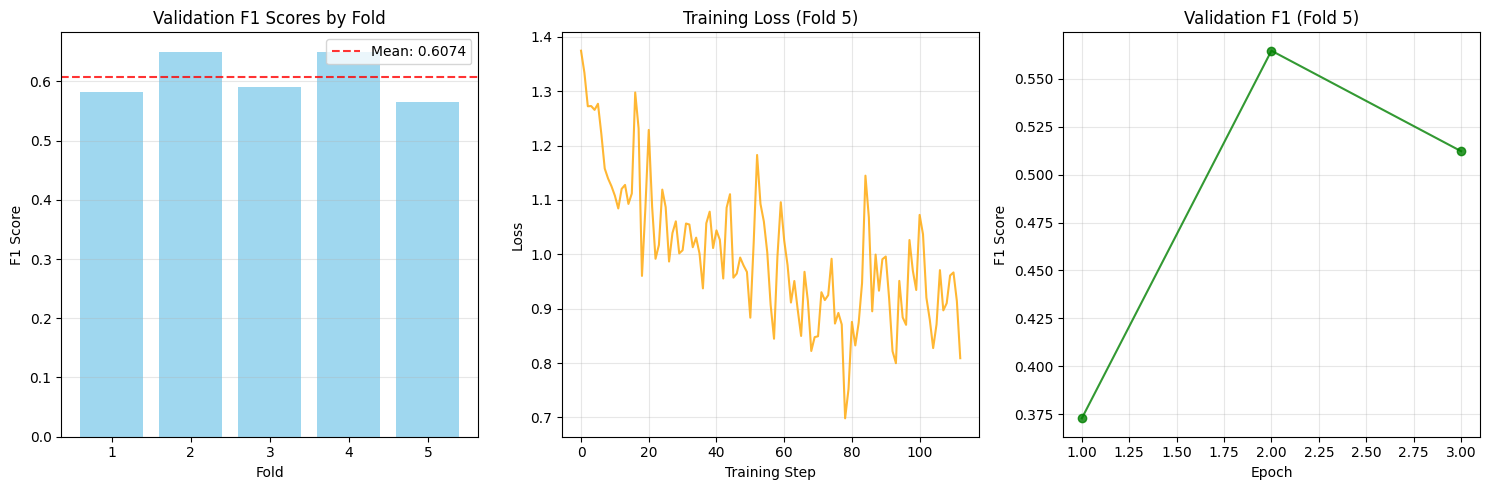

In [18]:
# 🎨 Visualize training progress
plt.figure(figsize=(15, 5))

# Plot 1: F1 scores across folds
plt.subplot(1, 3, 1)
plt.bar(range(1, K_FOLDS + 1), val_scores, color='skyblue', alpha=0.8)
plt.axhline(mean_cv_score, color='red', linestyle='--', alpha=0.8,
           label=f'Mean: {mean_cv_score:.4f}')
plt.title('Validation F1 Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Plot 2: Training loss progression (last fold)
plt.subplot(1, 3, 2)
if all_fold_results:
    last_fold_losses = all_fold_results[-1]['train_losses']
    # Smooth the losses for better visualization
    window_size = max(1, len(last_fold_losses) // 50)
    if len(last_fold_losses) > window_size:
        smoothed_losses = np.convolve(last_fold_losses,
                                    np.ones(window_size)/window_size, mode='valid')
        plt.plot(smoothed_losses, color='orange', alpha=0.8)
    else:
        plt.plot(last_fold_losses, color='orange', alpha=0.8)
plt.title(f'Training Loss (Fold {K_FOLDS})')
plt.xlabel('Training Step')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)

# Plot 3: Validation F1 progression (last fold)
plt.subplot(1, 3, 3)
if all_fold_results:
    last_fold_val_f1s = all_fold_results[-1]['val_f1s']
    plt.plot(range(1, len(last_fold_val_f1s) + 1), last_fold_val_f1s,
             color='green', marker='o', alpha=0.8)
plt.title(f'Validation F1 (Fold {K_FOLDS})')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Contributed by: Mohamed Eltayeb (He did everything) - Edited by: Ali Habibullah (I added comments and markdowns 😶‍🌫️)
